# Pairwise image refinement for sea ice segmentation

A challenge with sea ice segmentation for floe identification is that the distinction between neighboring floes is often difficult to identify. When segmenting individual images, algorithms often rely on morphological operations to separate neighboring pieces, for example eroding and dilating binary representations of the scene in order to break connections between floes. This method can work well in many conditions. However, typical segmentation methods do not take advantage of the existence of multiple images in series, as is available through, for exampling, overlapping swaths from repeat orbits.

Here we propose a method to iteratively refine an image segmentation for the purpose of sea ice floe identification with a pair of images. We leverage the assumption that ice floes are moving rigidly, while the background may deform. 

1. Initialize segmentation in both images by making a binary sea ice mask
2. Morphological operations to separate weak connections
3. Identification of markers
4. Initial estimate of the floe size: matching template
5. Get initial estimate of vectors for pairing features
6. Refine the estimate by finding optimal registration and rotation
7. Average the shapes to get a smoother estimate of the shape
8. Profit

The error metric is important - we want to find ideally one set of ice floes that maximizes a skill score across each image, minimizing the difference between the floes after pairing.

In [2]:
using Pkg
Pkg.activate("calval")
using IceFloeTracker
using Images
using Random

  Activating project at `~/Documents/research/calval_tgrs/notebooks/calval`


In [3]:
"""Utility functions for viewing segmentation results"""
# Return a random color of type RGB{N0f8}
function get_random_color(seed)
    Random.seed!(seed)
    rand(RGB{N0f8})
end

# Produce an image by replacing values inside a segment with the segment mean color
function view_seg(s)
    map(i->segment_mean(s,i), labels_map(s))
end

# Assign random colors to each segment (useful if viewing cluster results)
function view_seg_random(s)
    map(i->get_random_color(i), labels_map(s))
end


view_seg_random (generic function with 1 method)

In [4]:
dataset = Watkins2026Dataset()
cn = 63
cases = filter(f -> f.case_number == cn, dataset)
aqua = filter(f -> f.case_number == cn && f.satellite=="aqua", dataset)[1]
terra = filter(f -> f.case_number == cn && f.satellite=="terra", dataset)[1]

Case(GitHubLoader("https://github.com/danielmwatkins/ice_floe_validation_dataset/", "v0.1", "/tmp/Watkins2026"), DataFrameRow
 Row │        case_number  region        start_date  center_lon  center_lat  c ⋯
     │ Int64  Int64        String        Dates.Date  Float64     Float64     I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   125           63  beaufort_sea  2007-07-11    -128.157     75.5467  - ⋯
                                                              24 columns omitted)

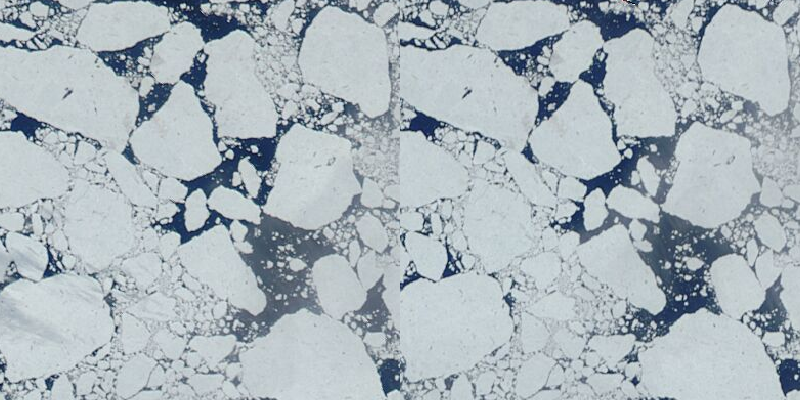

In [5]:
tc_imgs = modis_truecolor.(cases)
fc_imgs = modis_falsecolor.(cases)
mosaicview(tc_imgs, nrow=1)

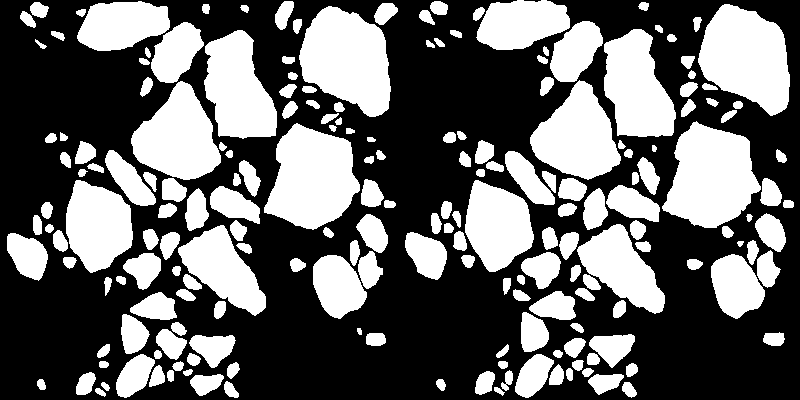

In [6]:
labeled_imgs = validated_binary_floes.(cases)
mosaicview(labeled_imgs, nrow=1)

In [7]:
segment = LopezAcosta2019Tiling.Segment()
segments = segment.(tc_imgs, fc_imgs, modis_landmask.(cases))

[ Info: building landmask and coastal buffer mask
[ Info: building landmask and coastal buffer mask


2-element Vector{SegmentedImage{Matrix{Int64}, RGBA{Float32}}}:
 Segmented Image with:
  labels map: 400×400 Matrix{Int64}
  number of labels: 183
 Segmented Image with:
  labels map: 400×400 Matrix{Int64}
  number of labels: 177

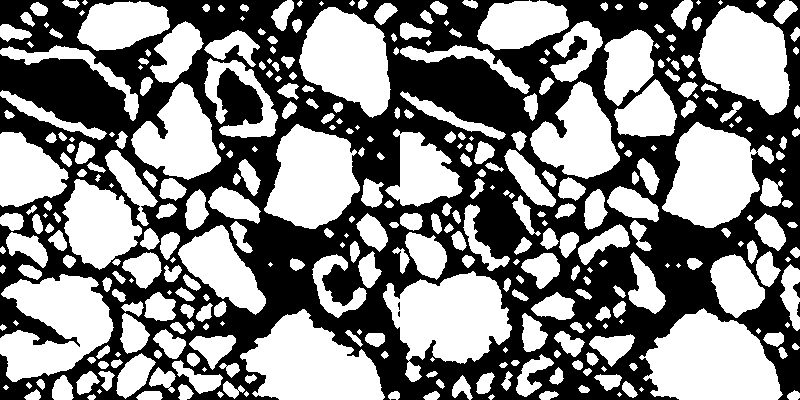

In [8]:
bin_segments = binarize_segments.(segments)
mosaicview(Gray.(bin_segments[1]), Gray.(bin_segments[2]), nrow=1) 

In [9]:
algo = IceDetectionLopezAcosta2019()
kseg = kmeans_segmentation(Gray.(tc_imgs[1]); k=4);
kbin = kmeans_binarization(Gray.(tc_imgs[1]), fc_imgs[1]; cluster_selection_algorithm=algo);

In [10]:
kbin2 = kmeans_binarization(Gray.(blue.(fc_imgs[1])), fc_imgs[1]; cluster_selection_algorithm=algo);

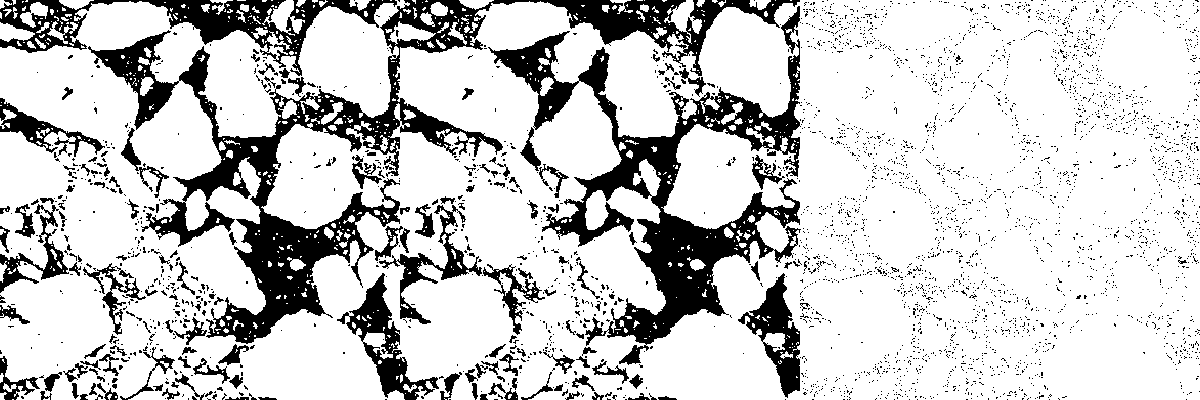

In [11]:
mosaicview(Gray.(kbin), Gray.(kbin2), Gray.(kbin .== kbin2), nrow=1)

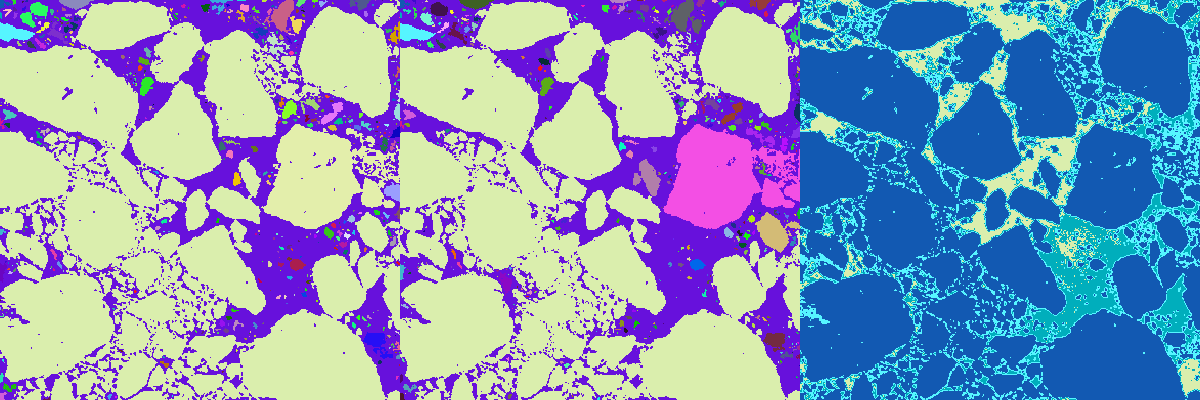

In [12]:
tcseg = SegmentedImage(labeled_imgs[1], label_components(kbin))
fcseg = SegmentedImage(labeled_imgs[1], label_components(kbin2))
mosaicview(view_seg_random(tcseg), view_seg_random(fcseg), view_seg_random(kseg), nrow=1)

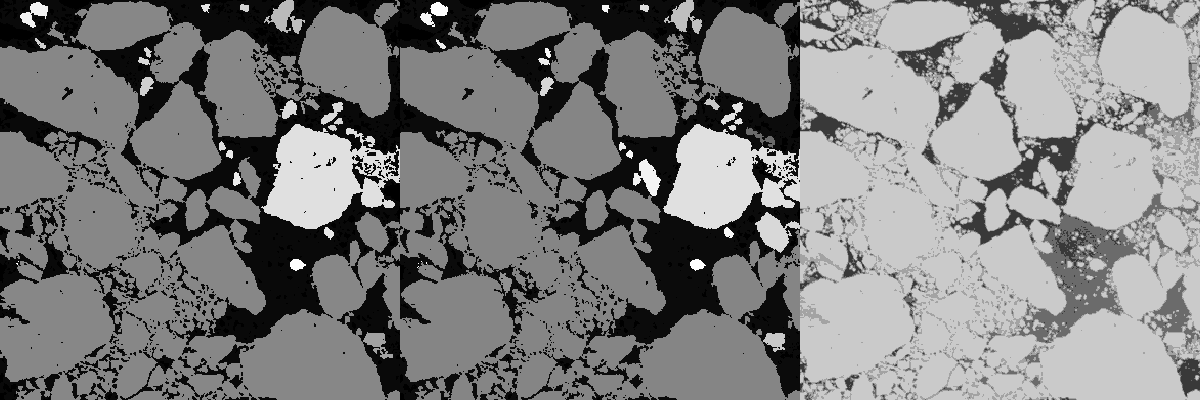

In [13]:
mosaicview(view_seg(tcseg), view_seg(fcseg), view_seg(kseg), nrow=1)

In [14]:
# validated image
lbseg = SegmentedImage(tc_imgs[1], label_components(labeled_imgs[1]))

# tiling algorithm defaults
laseg = segments[1]

# kmeans on the truecolor image, no preprocessing
tcseg = SegmentedImage(tc_imgs[1], label_components(kbin))

results_df = Dict()
recall, precision, fscore = segmentation_comparison(laseg, lbseg)
push!(results_df, "default" => [recall, precision, fscore])

recall, precision, fscore = segmentation_comparison(tcseg, lbseg)
push!(results_df, "kmeans" => [recall, precision, fscore])

Dict{Any, Any} with 2 entries:
  "default" => [0.655192, 0.871968, 0.748195]
  "kmeans"  => [0.53779, 0.974472, 0.693082]

In [15]:
using DataFrames
results_df = DataFrame(results_df)

Row,default,kmeans
,Float64,Float64
1,0.655192,0.53779
2,0.871968,0.974472
3,0.748195,0.693082


Things to try
- Use the tracker with the proximity method to get the set of matches
- Identify which ones are good matches
- Rotate and take image average to update the shape



The manually validated floe shapes provide us with a lower bound for measuring the shape properties and what a "good" segmentation would look like. We can use these to define an "end condition" for merging. What I need to figure out how to do is to apply measures of segmentation quality using Julia -- I've done most of the work with metrics in Python. 

Focusing first on the kmeans binarization output -- this step of the algorithm generally gives us a pretty-decent segmentation, in terms of marking bright floes as ice. It usually does not separate the floes very well.

We first assume that all the pixels selected in the kmeans binarization are *foreground* pixels, e.g., all of these belong to sea ice floes. This brings us to the problem that the floes intersecting the edge are not labeled in the validation dataset. Some basic categories of mismatch:
1. floes which intersect the boundary. Will be labeled by segmentation algorithm, not labeled in dataset
2. border pixels -- often different colors than the floe interior, either shaded from partial overlap of pixel, or bright from glint at ice edge
3. interior color differences -- melt ponds, cloud shadows, etc

## Metrics
1. Full-Image Precision
2. Full-Image Recall
3. Full-Image F-Score

The full-image metrics are computed already in the `segmentation_comparision` function. 

We also can consider the measures of clustering quality, which are often used in choosing e.g. the number of k-means clusters. Clustering.jl includes 5 indices of clustering quality. However, these are built around the Clustering objects not around SegmentedImages. The JuliaImages library does contain ImageDistances, which we can test out. It's got some basic ones like the manhattan and euclidean distances, and median absolute deviation. But helpfully it also includes the hausdorff and modified hausdorff distances.

For object-wise evaluation, I turn to the work I did earlier this year on the object wise evalution. There's the "relevant set" idea here where we grab all the segments fitting at least one of the four criteria:
1. Centroid S contained in G
2. Centroid G contained in S
3. Intersection S, G / size S greater than 0.5
4. Intersection S, G / size G greater than 0.5

With the relevant set, we can then compute some metrics. 
1. Distance to centroid
2. Modified Hausdorff distance
3. Undersegmentation (average precision)
4. Oversegmentation (average recall)
5. Shape dissimilarity metric (normalized by ground truth)
6. 


In [53]:
function relevant_set(
    ground_truth_label::Int,
    ground_truth_segments::SegmentedImage,
    predicted_segments::SegmentedImage)

    g_idxmap = labels_map(ground_truth_segments)
    s_idxmap = labels_map(predicted_segments)

    candidates_idx = g_idxmap .== ground_truth_label .&& s_idxmap .> 0
    candidates = unique(s_idxmap[candidates_idx])

    g_centroids = component_centroids(g_idxmap)
    s_centroids = component_centroids(s_idxmap)

    function g_fraction(ground_truth_label, candidate_label)
        g_area = sum(g_idxmap .== ground_truth_label)
        ov_area = sum(g_idxmap .== ground_truth_label .&&
                      s_idxmap .== candidate_label)
        return ov_area / g_area
    end

    function s_fraction(ground_truth_label, candidate_label)
        s_area = sum(s_idxmap .== candidate_label)
        ov_area = sum(g_idxmap .== ground_truth_label .&&
                      s_idxmap .== candidate_label)
        return ov_area / s_area
    end

    # basic check: round the centroid to the nearest whole number,
    # then check if that locations is nonzero in comparison image
    function centroid_check(centroid, comparison_image)
        row, col = round.(Int64, centroid)
        comparison_image[row, col] > 0
    end
    
    relevant_set_ = [c for c in candidates if
                g_fraction(ground_truth_label, c) > 0.5 ||
                s_fraction(ground_truth_label, c) > 0.5 ||
                centroid_check(g_centroids[ground_truth_label],
                    s_idxmap .== c) ||
                centroid_check(s_centroids[c],
                    g_idxmap .== ground_truth_label)
                ]
   return relevant_set_ 
end

relevant_set (generic function with 1 method)

In [47]:
# relevant_sets = Dict(
#     g => relevant_set(g, tcseg, lbseg) for g in unique(labels_map(tcseg)))

# for val in keys(relevant_sets)
#     if length(relevant_sets[val]) > 0
#         println(val, relevant_sets[val])
#     end
# end

In [48]:
relevant_sets = Dict(
    g => relevant_set(g, lbseg, laseg) for g in unique(labels_map(lbseg)))

Dict{Int64, Vector{Int64}} with 100 entries:
  5  => []
  56 => [98]
  35 => [72]
  55 => [97]
  60 => [106]
  30 => [64]
  32 => [65, 75]
  6  => [22]
  67 => [117]
  45 => [82]
  73 => [137]
  64 => [114]
  90 => [162]
  4  => [21]
  13 => [33]
  54 => [95]
  63 => [113]
  86 => [152]
  91 => [163]
  62 => [110]
  58 => [100]
  52 => [94]
  12 => [32]
  28 => [59]
  75 => [139]
  ⋮  => ⋮

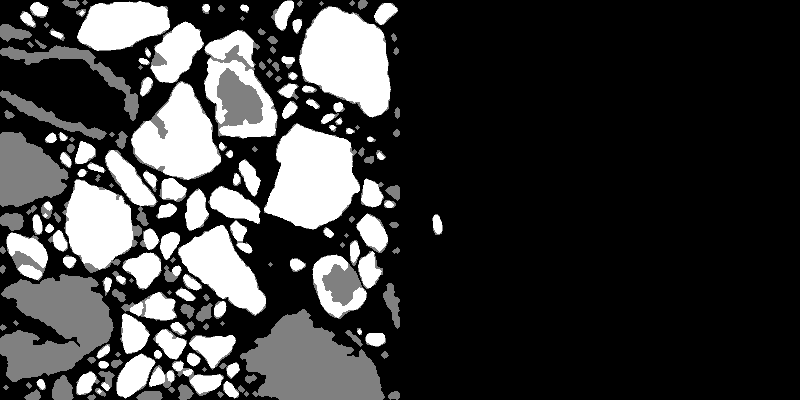

In [52]:
key = 4
mosaicview(0.5 .* Gray.(lbseg.image_indexmap .> 0)
    .+ 0.5 .* Gray.(laseg.image_indexmap .> 0), 
    0.5 .* Gray.(lbseg.image_indexmap .== key) 
    .+ 0.5 .* Gray.(laseg.image_indexmap .== relevant_sets[key]), nrow=1)